# BG/NBG model in PyMC

In this notebook we show how to port the BG/NBG model from the the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) (developed mainly by [Cameron Davidson-Pilon](https://github.com/CamDavidsonPilon)) package to [`pymc`](https://github.com/pymc-devs/pymc). The BG/NBG model, introduced in the seminal paper ["“Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) by Peter S. Fader, Bruce G. S. Hardie and Ka Lok Lee in 2005, is used to
> *predict future purchasing patterns, which can then serve as an input into “lifetime value” calculations, in the “non-contractual” setting (i.e., where the opportunities for transactions are continuous and the time at which customers become inactive is unobserved).*

Why to port the BG/NBG model to [`pymc`](https://github.com/pymc-devs/pymc)?

1. The[`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package is currently in "maintenance-mode", so we do not expect it to be further developed. In addition, I am not aware of other python implementation (the R community has more options available)
2. This current implementation does not allow for time-invariant external covariates even though is an easy extension an shown in the paper [Incorporating Time-Invariant Covariates into the Pareto/NBD and BG/NBD Models](http://brucehardie.com/notes/019/time_invariant_covariates.pdf) by Peter S. Fader and Bruce G. S. Hardie. There is actually an [open PR](https://github.com/CamDavidsonPilon/lifetimes/pull/342) to att his feature into the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package, but it is highly unlikely to be merged. Hence, as in practice time-invariant covariates could further segment user purchase patterns, writing this model explicitly can allow for more flexibility.
3. We can take advantage of the powerful bayesian machinery to have better uncertainty estimation and the possibility to use extend the base BG/NBG model to more complex ones, e.g. hierarchical models.

## Prepare Notebook

In [33]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
import pymc3 as pm
from scipy.special import expit
import theano.tensor as tt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We are going to use an existing data set from the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package documentation, see [here](https://lifetimes.readthedocs.io/en/latest/Quickstart.html).

In [ ]:
data_df = load_cdnow_summary(index_col=[0])

data_df.info()

From the package's documentation:

> - `frequency`: Number of repeat purchases the customer has made. More precisely, It’s the count of time periods the customer had a purchase in.
> - `T`: Age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` Age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.

In [ ]:
data_df.head()

Let us extract the data as arrays and recover the notation from the original papers.

In [ ]:
n = data_df.shape[0]
x = data_df["frequency"].to_numpy()
t_x = data_df["recency"].to_numpy()
T = data_df["T"].to_numpy()

## BG/NBD Model (Lifetimes)

We do not want to give a detailed description of the model, so we will just show the notation. Please refer to the original papers for more details, e.g. ["“Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf).

<center>
<img src="bg_nbg_model_description.png" height=500 />
</center>

We nos use the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) object [`BetaGeoFitter`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#module-lifetimes.fitters.beta_geo_fitter) to estimate the model parameters via maximum likelihood estimation.

In [ ]:
# fit BG/NBG model
bgf = BetaGeoFitter()
bgf.fit(frequency=x, recency=t_x, T=T)

bgf.summary

Note that the models provide confidence intervals for the estimated parameters.

### Full Bayesian Model

A nice `pymc` implementation of the full bayesian model can be found in the blog post [Implementing Fader Hardie (2005) in pymc3](https://sidravi1.github.io/blog/2018/07/08/fader-hardie-clv) by [Sid Ravinutala](https://sidravi1.github.io/about.html). In this post, the author uses the complete likelihood function (Equation (3) in ["“Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf)):

$$
L(\lambda, p | X=x, T) = (1 - p)^{x}\lambda^{x}e^{-\lambda T} + \delta_{X > 0}p(1 - p)^{x - 1}\lambda^x e^{-\lambda t_x}
$$

Here is the model in `pymc`:

In [ ]:
# convenient indicator function
int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)


with pm.Model() as model_full:

    # hyper priors for the Gamma params    
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    # hyper priors for the Beta params
    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    lam = pm.Gamma(name="lam", alpha=r, beta=alpha, shape=n)
    p = pm.Beta(name="p", alpha=a, beta=b, shape=n)

    def logp(x, t_x, T, x_zero):
        log_term_a = x * tt.log(1 - p) + x * tt.log(lam) - t_x * lam
        term_b_1 = -lam * (T - t_x)
        term_b_2 = tt.log(p) - tt.log(1 - p)
        log_term_b = pm.math.switch(x_zero, pm.math.logaddexp(term_b_1, term_b_2), term_b_1)

        return tt.sum(log_term_a) + tt.sum(log_term_b)

    likelihood = pm.DensityDist(
        name="likelihood",
        logp=logp,
        observed = {"x":x, "t_x":t_x, "T":T, "x_zero": x_zero}
    )

In [ ]:
with model_full:
    trace_full = pm.sample(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )

This model takes a while to run and the results coincide with the ones from obtained using `lifetimes`.

In [24]:
axes = az.plot_trace(
    data=trace_full,
    var_names=["a", "b", "alpha", "r"],
    lines=[(k, {}, [v]) for k, v in bgf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Full BG/NBG Model Trace");

**Remark:** The chains for `a` and `b` do not look so good. See the `r_hat` values below.

In [23]:
az.summary(data=trace_full, var_names=["a", "b", "alpha", "r"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.925  0.262   0.518    1.423      0.028    0.020      96.0     117.0   
b      2.994  1.059   1.412    4.970      0.110    0.078     101.0     154.0   
alpha  4.475  0.378   3.741    5.163      0.007    0.005    2818.0    5713.0   
r      0.244  0.012   0.221    0.268      0.000    0.000    2051.0    3459.0   

       r_hat  
a       1.02  
b       1.02  
alpha   1.00  
r       1.00

## Bayesian Model: Randomly Chosen Individual

The main limitation (computationally) of the `model_full` is that we have $\lambda$ and $p$ parameters per user. This of course does not scale well. That is why in practice one usually takes the expectation over $\lambda$ and $p$ to study a randomly chosen individual. One can compute this expectation analytically, see Section $5$ in ["“Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf) for the mathematical details. What is important to remark is this the end expression for the log-likelihood is relatively easy to write. Actually, the authors of the paper have a document twhich describe how to estimate the corresponding parameters in Excel, see [Implementing the BG/NBD Model for
Customer Base Analysis in Excel](http://brucehardie.com/notes/004/bgnbd_spreadsheet_note.pdf). The resulting expression for the likelihood function is:

$$
L(a, b, \alpha, r|X=x, t_x, T) = A_{1}A_{2}(A_{3} + \delta_{x>0}A_4)
$$

where

\begin{align*}
A_{1} & = \frac{\Gamma(r + x)\alpha^{{r}}}{\Gamma(x)} \\
A_{2} & = \frac{\Gamma(a + b)\Gamma(b + x)}{\Gamma(b)\Gamma(a + b + x)} \\
A_{3} & = \left(\frac{1}{\alpha + T}\right)^{r+x} \\
A_{4} & = \left(\frac{a}{b + x - 1}\right)\left(\frac{1}{\alpha + t_x}\right)^{r + x}
\end{align*}

Computing the $\log (L(a, b, \alpha, r|X=x, t_x, T))$ is straight forward from these explicit expressions $a_{i}\coloneqq \log(A_{i})$. Note however that one has to be careful with the $a_{4}\coloneqq \log(A_4)$ term since we need to ensure that $b + x - 1 >0$ (otherwise should be zero). Fortunately, we wan simple re-factor the log-likelihood method code of th `lifetimes`'s `BetaGeoFitter` class from `numpy` to `theano` (see [`lifetimes.BetaGeoFitter._negative_log_likelihood`](https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/fitters/beta_geo_fitter.py#L164)). 

In [28]:
with pm.Model() as model:
   
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    def logp(x, t_x, T, x_zero):
        a1 = tt.gammaln(r + x) - tt.gammaln(r) + r * tt.log(alpha)
        a2 = tt.gammaln(a + b) + tt.gammaln(b + x) - tt.gammaln(b) - tt.gammaln(a + b + x)
        a3 = -(r + x) * tt.log(alpha + T)
        a4 =  tt.log(a) - tt.log(b + tt.maximum(x, 1) - 1) - (r + x) * tt.log(t_x + alpha)
        max_a3_a4 = tt.maximum(a3, a4)
        ll_1 = a1 + a2 
        ll_2 = tt.log(tt.exp(a3 - max_a3_a4) + tt.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)) + max_a3_a4
        return tt.sum(ll_1 + ll_2)

    likelihood = pm.DensityDist(
        name="likelihood",
        logp=logp,
        observed = {"x":x, "t_x":t_x, "T":T, "x_zero": x_zero}
    )

Let us compute the posterior distributions:

In [29]:
with model:
    trace = pm.sample(
        tune=3000,
        draws=6000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, b, a]


Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 142 seconds.


This model is much faster to train! We can now take a look at the traces and summary.

In [30]:
axes = az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in bgf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBG Model Trace");

In [34]:
az.summary(data=trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.967  0.277   0.544    1.484      0.003    0.002    9591.0    8896.0   
b      3.162  1.147   1.471    5.244      0.013    0.009    9514.0    9128.0   
alpha  4.473  0.388   3.766    5.226      0.004    0.003    9842.0   11398.0   
r      0.244  0.013   0.220    0.268      0.000    0.000    9595.0   11236.0   

       r_hat  
a        1.0  
b        1.0  
alpha    1.0  
r        1.0

The summary statistics look overall good. In particular the chains values for `a` and `b` look better than the `model_full`.

Now that we have posterior samples for the model parameters we can easily compute quantities of interest. For example, let us compute the *conditional probability of being alive*, see the note [Computing P(alive) Using
the BG/NBD Model](https://brucehardie.com/notes/021/palive_for_BGNBD.pdf). Again, we can simply port the corresponding method from [`lifetimes.BetaGeoFitter.conditional_probability_alive`](https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#lifetimes.fitters.beta_geo_fitter.BetaGeoFitter.conditional_probability_alive).

In [35]:
# See https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]


def conditional_probability_alive(trace, x, t_x, T):
    n_vals = x.shape[0]

    a = _sample(array=trace.posterior["a"].to_numpy(), n_samples=n_vals)
    b = _sample(array=trace.posterior["b"].to_numpy(), n_samples=n_vals)
    alpha = _sample(array=trace.posterior["alpha"].to_numpy(), n_samples=n_vals)
    r = _sample(array=trace.posterior["r"].to_numpy(), n_samples=n_vals)

    log_div = (
        (r + x[..., None]) * np.log((alpha + T[..., None]) / (alpha + t_x[..., None]))
        + np.log(a / (b + np.maximum(x[..., None], 1) - 1))
    )
    return np.where(x[..., None] == 0, 1.0, expit(-log_div))


p_alive_sample = conditional_probability_alive(trace, x, t_x, T)

We compute these probabilities directly from the `BetaGeoFitter` object directly so that we could compare the results.

In [36]:
p_alive = bgf.conditional_probability_alive(x, t_x, T)

We can simply plot some example predictions:

/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to 

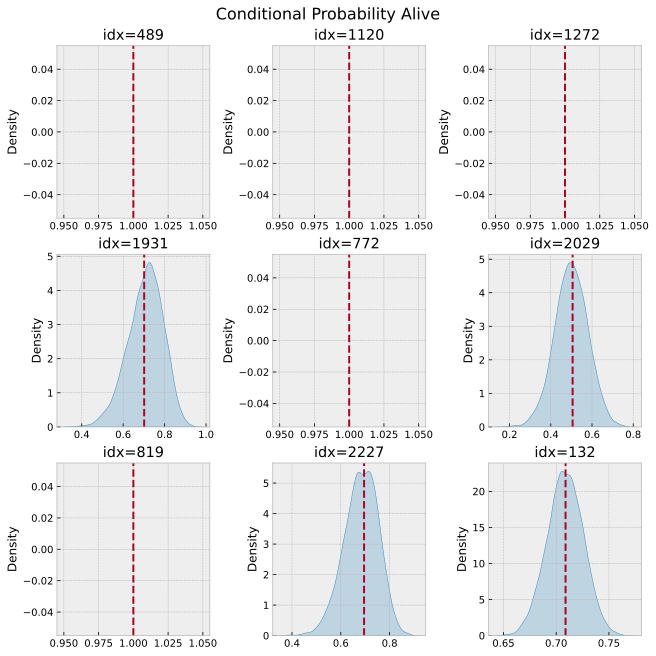

In [49]:
def plot_conditional_probability_alive(p_alive_sample, p_alive, idx, ax):
    sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
    ax.axvline(x=p_alive[idx], color="C1", linestyle="--")
    ax.set(title=f"idx={idx}")
    return ax

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 9),
    layout="constrained"
)
for ax in axes.flatten():
    idx = np.random.choice(range(n))
    plot_conditional_probability_alive(p_alive_sample, p_alive, idx, ax)

fig.suptitle("Conditional Probability Alive", fontsize=16);

Note for example that for `idx=489` we have:

In [56]:
idx = 489
# probability estimation lifetimes model
p_alive[idx]

1.0

In [57]:
# posterior samples
np.unique(p_alive_sample[idx])

array([1.])

Hence, the bayesian model also captures the case when the user is certainly alive (because did a very recent purchase).

Finally we can compare both model's parameters.

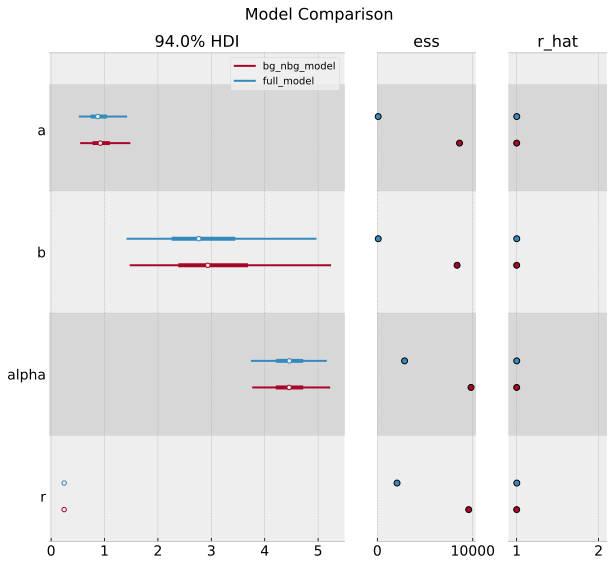

In [72]:
axes = az.plot_forest(
    data=[trace_full, trace],
    model_names=["full_model", "bg_nbg_model"],
    var_names=["a", "b", "alpha", "r"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(10, 9)
)
plt.gcf().suptitle("Model Comparison", y=0.95, fontsize=16);

We indeed see that the `full_model` has a lower [`ess`](https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html).